Algoritmo incremental implementado.

In [4]:
import math
import copy
from typing import List, Tuple, Dict, Set

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

Point   = Tuple[float, float]
Polygon = List[Point]


def dot(a: Point, b: Point) -> float:
    """Calcula o produto escalar de dois vetores 2D."""
    return a[0] * b[0] + a[1] * b[1]


def halfspace_p_closer_than_q(p: Point, q: Point) -> Tuple[Point, float]:
    """Retorna (n, c) definindo o meio-espaço n·x <= c para pontos mais próximos de p que de q."""
    vx, vy = q[0] - p[0], q[1] - p[1]
    n = (vx, vy)
    c = (q[0] ** 2 + q[1] ** 2 - p[0] ** 2 - p[1] ** 2) / 2
    return n, c


def clip_polygon(poly: Polygon, n: Point, c: float) -> Polygon:
    """Recorta um polígono convexo pelo meio-espaço n·x <= c."""
    if not poly:
        return []
    new_poly: Polygon = []
    m = len(poly)
    for i in range(m):
        A, B = poly[i], poly[(i + 1) % m]
        a_in = dot(n, A) <= c + 1e-9
        b_in = dot(n, B) <= c + 1e-9
        if a_in and b_in:
            new_poly.append(B)
        elif a_in and not b_in:
            t = (c - dot(n, A)) / dot(n, (B[0] - A[0], B[1] - A[1]))
            new_poly.append((A[0] + t * (B[0] - A[0]), A[1] + t * (B[1] - A[1])))
        elif not a_in and b_in:
            t = (c - dot(n, A)) / dot(n, (B[0] - A[0], B[1] - A[1]))
            inter = (A[0] + t * (B[0] - A[0]), A[1] + t * (B[1] - A[1]))
            new_poly.extend([inter, B])
    return new_poly


def incremental_voronoi(
    points: List[Point],
    bbox: Polygon,
    record_frames: bool = False
) -> Tuple[Dict[Point, Polygon], List[Dict[Point, Polygon]]]:
    """Calcula o diagrama de Voronoi incremental para um conjunto de pontos dentro de uma caixa delimitadora."""
    cells: Dict[Point, Polygon] = {}
    frames: List[Dict[Point, Polygon]] = []
    for p in points:
        cell = bbox.copy()
        for q in list(cells):
            n, c = halfspace_p_closer_than_q(p, q)
            cell     = clip_polygon(cell,              n,  c)
            cells[q] = clip_polygon(cells[q], (-n[0], -n[1]), -c)
            if not cells[q]:
                del cells[q]
        cells[p] = cell
        if record_frames:
            frames.append(copy.deepcopy(cells))
    return cells, frames


def build_adjacency(vor: Dict[Point, Polygon]) -> Dict[Point, Set[Point]]:
    """Constroi a adjacência de vizinhança: pontos que compartilham uma aresta se suas células compartilharem pelo menos dois vértices."""
    adj: Dict[Point, Set[Point]] = {p: set() for p in vor}
    for p, poly_p in vor.items():
        verts_p = set(poly_p)
        for q, poly_q in vor.items():
            if p == q:
                continue
            if len(verts_p.intersection(poly_q)) >= 2:
                adj[p].add(q)
    return adj


def run_voronoi(
    points: List[Point],
    print_final_graph: bool = True,
    animated: bool = False,
    filename: str = "voronoi_incremental.mp4",
    fps: int = 2
) -> Dict[Point, Polygon]:
    """
    Constrói o diagrama de Voronoi, opcionalmente exibe o gráfico final,
    e retorna a lista de adjacência das células (vizinhos).

    O recorte é aplicado apenas dentro dos limites do plot (sem bordas infinitas).

    :param points: lista de tuplas (x, y)
    :param print_final_graph: se True, exibe o gráfico do diagrama
    :return: dicionário mapeando cada ponto ao seu conjunto de vizinhos
    """
    xs, ys = zip(*points)
    x_min, x_max = min(xs) - 1, max(xs) + 1
    y_min, y_max = min(ys) - 1, max(ys) + 1
    bbox = [(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)]

    vor, frames = incremental_voronoi(points, bbox, record_frames=animated)

    if animated and frames:
        fig, ax = plt.subplots()
        def draw_state(cells, highlight_idx=-1):
            ax.clear()
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_aspect('equal')
            ax.set_title('Construção incremental do diagrama de Voronoi')
            for idx, (site, poly) in enumerate(cells.items()):
                if len(poly) < 3:
                    continue
                cx = sum(x for x, _ in poly) / len(poly)
                cy = sum(y for _, y in poly) / len(poly)
                poly = sorted(poly, key=lambda p: math.atan2(p[1]-cy, p[0]-cx))
                xs_poly, ys_poly = zip(*(poly + [poly[0]]))
                color = 'tab:red' if idx == highlight_idx else 'k'
                ax.plot(xs_poly, ys_poly, color=color, linewidth=1.2)
            ax.scatter(xs[:highlight_idx+1], ys[:highlight_idx+1], c='red', zorder=3)
        def update(frame_idx):
            draw_state(frames[frame_idx], frame_idx)
        anim = FuncAnimation(fig, update, frames=len(frames), interval=1000 // fps, repeat=False)
        writer = FFMpegWriter(fps=fps)
        anim.save(filename, writer=writer)
        plt.close(fig)
        print(f"Animação salva em “{filename}”.\n")

    if print_final_graph:
        fig, ax = plt.subplots()
        for poly in vor.values():
            if len(poly) < 3:
                continue
            cx = sum(x for x, _ in poly) / len(poly)
            cy = sum(y for _, y in poly) / len(poly)
            poly = sorted(poly, key=lambda p: math.atan2(p[1]-cy, p[0]-cx))
            xs_poly, ys_poly = zip(*(poly + [poly[0]]))
            ax.plot(xs_poly, ys_poly, color='k')
        ax.scatter(xs, ys, c='red', zorder=3)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_aspect('equal')
        ax.set_title('Diagrama de Voronoi (final)')
        plt.show()

    for site, cell in vor.items():
        print(f"Point {site}: {cell}")

    return vor


# Para testar o algoritmo, mude a váriavel "pts" abaixo e rode o algoritmo. 
Se quiser apenas a representação textual, mude a variável "print_final_graph" para "False". Se quiser uma animação em mp4, mude a variável "animated" para True. Se quiser gerar pontos aleatórios, utilize a função "generate_random_points" como pode ser visto abaixo. Caso contrário, passe uma array de pontos no formato [(a,b), (c,d), (e,f), ... (y,z)]

In [5]:
import random
random.seed(42)
def generate_random_points(num_points, l=10):
    """o parâmetro l determina o limite dos valores de x e y para os quais serão gerados os pontos"""
    return [(random.uniform(-l, l), random.uniform(-l, l)) for _ in range(num_points)]

O print das regiões ficou limitado ao limite do grafico. Portanto, as caixas que estão "limitadas" pelos limites do gráfico em plaintext na verdade se estendem para o infinito

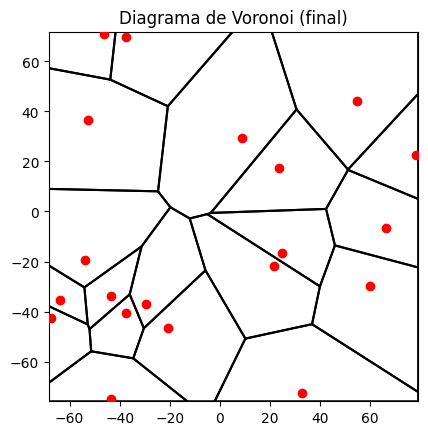

Point (32.73149379438776, -72.66809861509404): [(-1.9938808143896765, -75.86396097535396), (79.32373610185525, -75.86396097535396), (79.32373610185525, -72.14986607400616), (36.918607506826646, -45.053240382377425), (10.271093801875793, -50.80757538002411)]
Point (-43.5362758957525, -33.69792582366286): [(-35.96266794417036, -33.12737542008945), (-31.23001536930728, -13.98547854105428), (-54.07200517163922, -30.342237077936478), (-52.74045177914551, -45.145512848685804), (-52.02461822103645, -47.018744894665446)]
Point (-67.2332836922196, -42.75345818223517): [(-51.36179143239386, -55.885173147573425), (-52.02461822103644, -47.01874489466545), (-52.74045177914553, -45.14551284868574), (-68.2332836922196, -37.87294258336796), (-68.2332836922196, -68.4327091033012)]
Point (-63.83977129444334, -35.52422350238526): [(-52.740451779145516, -45.14551284868574), (-54.07200517163922, -30.34223707793648), (-68.2332836922196, -21.634483414336117), (-68.2332836922196, -37.872942583367944)]
Point (

In [7]:
# MUDE apenas ESSAS VARIÁVEIS
points = generate_random_points(num_points=20, l=80)
print_final_graph = True
animated = False

if __name__ == '__main__':
    diagram = run_voronoi(points, animated=animated, print_final_graph=print_final_graph)